# CS4487 - Machine Learning
# Lecture 7 - Linear Dimensionality Reduction
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Dimensionality Reduction for Vectors
  1. Principal Component Analysis (PCA)  
  2. Random Projections
  3. Fisher's Linear Discriminant (FLD)
2. **Linear Dimensionality Reduction for Text**
  1. Latent Semantic Analysis (LSA)  
  2. Non-negative Matrix Factorization (NMF)
  3. Latent Dirichlet Allocation (LDA)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Dimensionality Reduction
- **Goal:** Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data represent co-occuring features in high-dim data.
  - Dimensions in the low-dim data may have semantic meaning.
- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<center><img src="imgs/topic.png" width=500px></center>

# Latent Semantic Analysis (LSA)
- Also called _Latent Semantic Indexing_
- Consider a bag-of-word representation (e.g., TF, TF-IDF)
  - document vector $\mathbf{x}_i$ 
  - $x_{i,j}$ is the frequency of word $j$ in document $i$

- Approximate each document vector as a weighted sum of topic vectors.
  - $\hat{\mathbf{x}} = \sum_{n=1}^p w_p \mathbf{v}_p$
  - Topic vector $\mathbf{v}_p$ contains co-occuring words.
    - corresponds to a particular _topic_ or _theme_.
  - Weight $w_p$ represents similarity of the document to the p-th topic.
- Objective: 
  - minimize the squared reconstruction error (Similar to PCA):
  - $\min_{\mathbf{v},\mathbf{w}} \sum_i ||\mathbf{x}_i - \hat{\mathbf{x}}_i||^2$

- Represent each document by its topic weights.
  - Apply other machine learning algorithms...
- **Advantage:**   
  - Finds relations between terms (synonymy and polysemy).
  - distances/similarities are now comparing topics rather than words.
    - higher-level semantic representation

# Example on Spam Email dataset
- use bag-of-words representation with 50 words
- term-frequency (TF) normalization

In [2]:
# Load spam/ham text data from directories
textdata = datasets.load_files("email", encoding="utf8", decode_error="replace")

# convert to bag-of-words representation
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=50)
X = cntvect.fit_transform(textdata.data)
Y = textdata.target

# TF representation
tf_trans = feature_extraction.text.TfidfTransformer(norm='l1', use_idf=False)
Xtf = tf_trans.fit_transform(X)

# print the vocabulary
print(cntvect.vocabulary_)

{'online': 39, 'watches': 49, 'brands': 13, 'bags': 11, 'new': 35, 'today': 46, 'hi': 25, 'peter': 42, 'contact': 17, 'mr': 34, 'email': 21, 'com': 16, 'number': 37, 'country': 19, 'nigeria': 36, 'answer': 10, 'status': 44, 'good': 23, 'day': 20, 'john': 30, 'united': 47, 'payment': 40, 'bank': 12, 'address': 9, 'information': 28, 'inform': 27, '10': 2, 'office': 38, 'kamara': 32, '000': 1, 'codeine': 15, '30mg': 6, '30': 5, '00': 0, '60': 8, 'pills': 43, '120': 3, 'just': 31, 'cost': 18, 'buy': 14, 'mg': 33, 'percocet': 41, '50': 7, '15mg': 4, 'visa': 48, 'isidoro': 29, 'store': 45, 'http': 26, 'google': 24, 'files': 22}


# LSA on Spam data
- Apply LSA  with 5 topics
  - implemented as `TruncatedSVD`

In [3]:
lsa = decomposition.TruncatedSVD(n_components=5, random_state=4487)
Wlsa = lsa.fit_transform(Xtf) 

# components
V = lsa.components_ 

In [4]:
rbow = plt.get_cmap('rainbow')
def get_top_word_inds(T, vocab, mode='1std'):
    # return indices of the largest component entries    
    absT = abs(T)
    
    # get 5 largest values
    if (mode=='top5'):
        tmp = argsort(absT)[::-1]
        topinds = tmp[0:5]
            
    elif (mode=='accum'):
        # select by accumulating
        tmpx = argsort(absT)[::-1]
        mags = absT[tmpx]
        magsc = cumsum(mags)
        magsc /= magsc[-1]
        #print magsc    
        cumu = sum(magsc < 0.50)
        topinds = tmpx[0:cumu]
        
    elif ('1std'):
        # select words with magnitude of 1-std above mean
        mymn = mean(absT)
        mystd = std(absT)
        topinds = where(absT > mymn+mystd)[0]
        
    # get the words
    topwords = []
    for q in topinds:
        mystr = vocab[q]
        if T[q]<0:
            mystr = "!" + mystr            
        topwords.append(mystr)
            
    return topinds, topwords

def get_model(model):
    if model.__class__.__name__ == 'LatentDirichletAllocation':
        K = model.components_.shape[0]
        comps = model.components_.copy()
        # normalize to a probability distribution
        comps /= sum(comps,axis=1)[:,newaxis]
    else:
        K = model.n_components
        comps = model.components_
    return (K, comps)

def plot_topics(model, vocab, ind=None, figsize=(8,10), sp=None):
    # ind= topic indices to plot
    # figsize= figure size
    # sp= subplot indices (use None for default): [sy, sx, inds]
    K, comps = get_model(model)

    Xr = arange(model.components_.shape[1])
    lsafig = plt.figure(figsize=figsize)
    
    if ind is None:
        ind = range(K)
    if sp is None:
        sy = len(ind)
        sx = 1
        spinds = range(1,sy+1)
    else:
        sy = sp[0]
        sx = sp[1]
        spinds = sp[2:]
    
    for ip,j in enumerate(ind):
        plt.subplot(sy,sx,spinds[ip])
        # get components
        T = comps[j,:]

        tmp,topwords = get_top_word_inds(T, vocab)
    
        plt.bar(Xr, T, color="", edgecolor='k')
        plt.plot(tmp, T[tmp], 'bo')
        # plot words on the top 5
        TW = []
        for i,q in enumerate(tmp):
            mystr = topwords[i]
            plt.annotate(xy=(q+0.4,T[q]), s=mystr, 
                         xytext=(q+0.4,T[q]), rotation=45, 
                         ha='left', va='bottom', color='red')
        plt.grid(True)
        plt.ylabel('Topic ' + str(j+1))
        if ip == sy-1:
            plt.xlabel('words')
        plt.xlim(Xr[0]-0.5, Xr[-1]+.5)
    if sp is None:
        plt.close()
    return lsafig

# Topic vectors
- topic vectors contain frequent co-occuring words

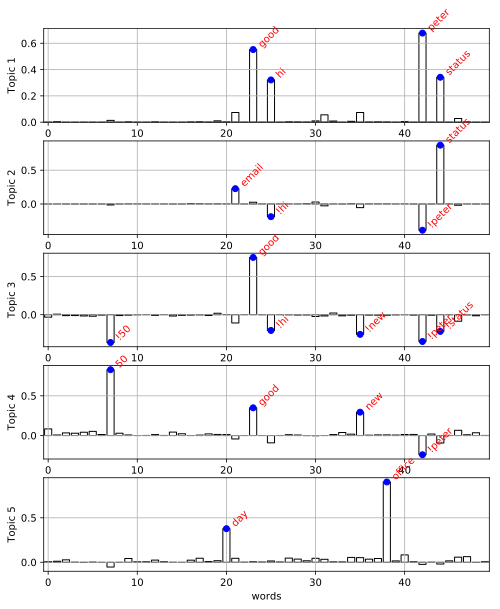

In [5]:
vocab = asarray(cntvect.get_feature_names())
lsafig = plot_topics(lsa, vocab)
lsafig

# Document representation
- Documents are a combination of topics

In [6]:
def plot_doc_topic(myXtf, myW, model, vocab):    
    docfig = plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    K, comps = get_model(model)
    Xr = arange(comps.shape[1])
    myXtfa = myXtf.toarray().flatten()
    plt.bar(Xr, myXtfa, lw=1, color="", label='document', edgecolor='k')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    for j in range(K):
        T = comps[j,:]
        mystr = "Topic " + str(j+1) + " ($w_"+str(j+1)+"$=% .4f"%(myW[j],) + ") "
               
        # get largest values, and add words
        tmp, topwords = get_top_word_inds(T, vocab)
        mystr += " ".join(topwords)
        plt.bar(Xr, myW[j]*T, color="", edgecolor=rbow(float(j)/K), lw=2, label=mystr)
        
    plt.grid(True); plt.xlabel('words')
    tmpax = plt.axis()
    plt.axis([Xr[0]-0.5, Xr[-1]+0.5, tmpax[2], 1.0])
    plt.legend(fontsize=8, loc='upper center')

    plt.subplot(2,1,2)
    plt.bar(Xr, myXtfa, lw=1, color="", label='original document', edgecolor='k')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    newX = dot(myW[newaxis,:],comps).flatten()
    plt.bar(Xr, newX, color="", edgecolor='r', lw=2, label='reconstruction')
    
    # get largest values
    cols = ('black', 'red')
    for i,T in enumerate([myXtfa, newX]):
        if i==0:
            tmp = where(abs(T)>=0.1)[0]
        else:
            tmp = where((abs(T)>=0.1) & (abs(myXtfa)<0.1))[0]
        #plt.plot(tmp+0.4, T[tmp], 'ko')
        for q in tmp:
            mystr = vocab[q]
            if T[q]<0:
                mystr = "!" + mystr
            plt.annotate(xy=(q+0.4,T[q]), s=mystr, 
                         xytext=(q+0.4,T[q]), rotation=45, 
                         ha='left', va='bottom', color=cols[i])
            
    plt.grid(True)
    plt.xlabel('words')
    plt.axis([Xr[0]-0.5, Xr[-1]+0.5, tmpax[2], 1.0])
    plt.legend(fontsize=8, loc='upper center')
    plt.close()
    return docfig

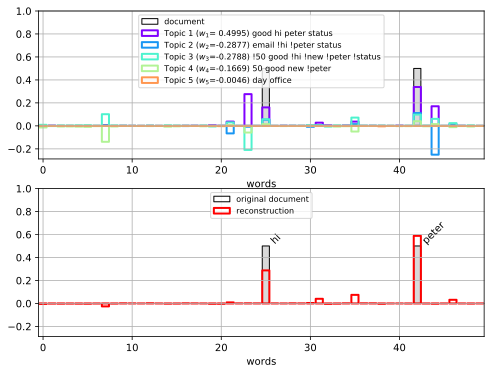

In [7]:
plot_doc_topic(Xtf[2,:], Wlsa[2,:], lsa, vocab)

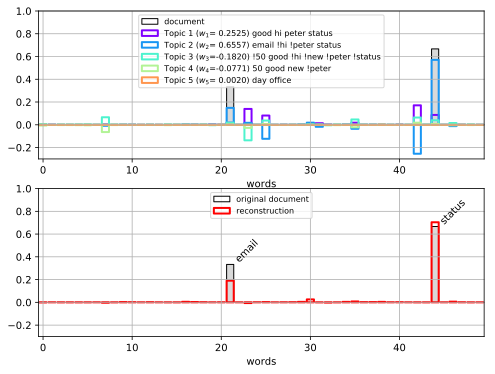

In [8]:
plot_doc_topic(Xtf[4,:], Wlsa[4,:], lsa, vocab)

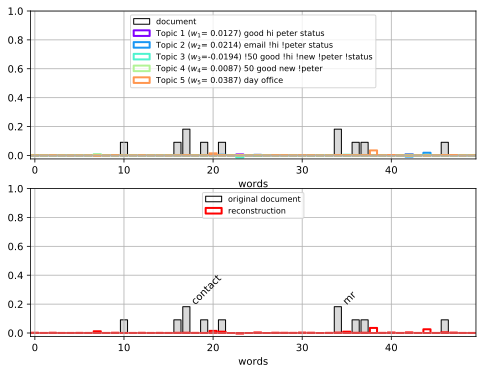

In [9]:
plot_doc_topic(Xtf[3,:], Wlsa[3,:], lsa, vocab)

# Problem with LSA
- In the topic vector, the "frequency" of a word can be negative!
  - Doesn't really make sense for document bag-of-words model.

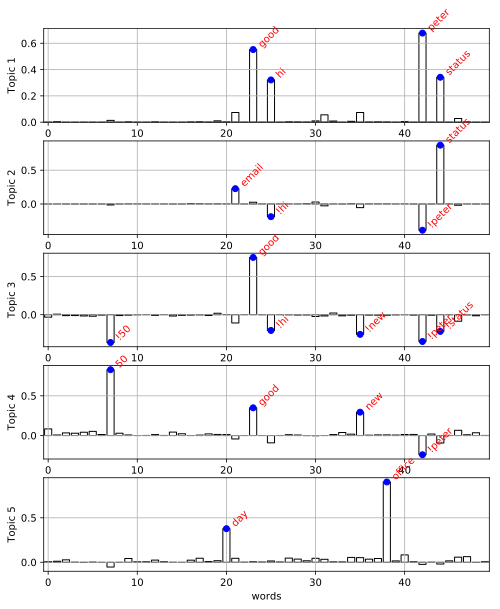

In [10]:
lsafig

# Problems with LSA
- The weights for each topic can be negative!
  - Topics should only be "additive"
    - Topics should increase probability of some topic-related words, but not decrease probability of other words.
    - It doesn't make sense to "remove" a topic using a negative topic weight.

In [11]:
pfig = plt.figure(figsize=(9,3))
for i,e in enumerate([2, 4, 7, 16]):
    plt.subplot(1,4,i+1)
    plt.bar(range(5), Wlsa[e,:], edgecolor='k')
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([-0.5 ,4.5,-0.3,1])
plt.close()

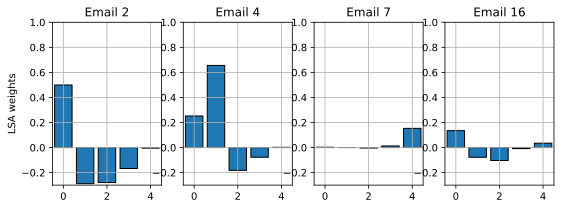

In [12]:
pfig

# Non-negative Matrix Factorization (NMF)
- **Solution:** constrain the topic vector and weights to be non-negative.
- Similar to LSA
  - Approximate each document vector as a weighted sum of topic vectors.
    - $\hat{\mathbf{x}}_j = \sum_{n=1}^p w_p \mathbf{v}_p$
    - But now, each entry of topic vector $\mathbf{v}_p\geq 0$ and topic weight $w_p\geq 0$
  - Objective: minimize the squared reconstruction error
    - $\min_{\mathbf{v},\mathbf{w}} \sum_j ||\mathbf{x}_j - \hat{\mathbf{x}}_j||^2$
    - subject to the non-negative constraints.

In [13]:
# Run NMF
nmf = decomposition.NMF(n_components=5)
Wnmf = nmf.fit_transform(Xtf) 

# components
V = nmf.components_ 

# Topic vector
- all non-negative entries
- looks much cleaner (less small entries)

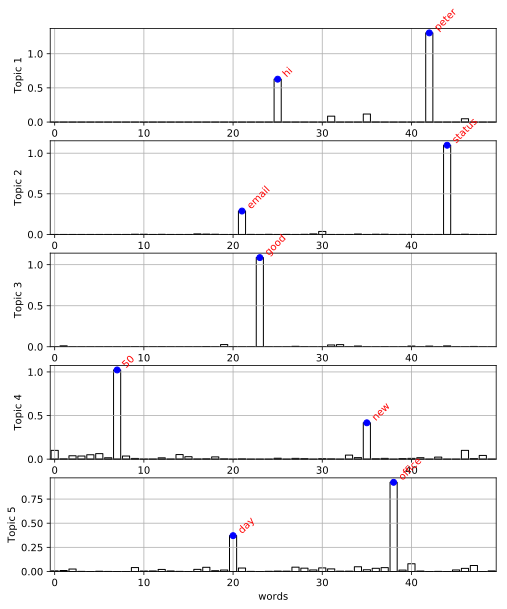

In [14]:
plot_topics(nmf, vocab)

# Document vector
- additive combination of topics

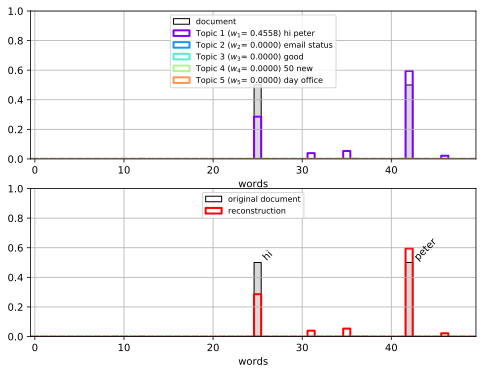

In [15]:
plot_doc_topic(Xtf[2,:], Wnmf[2,:], nmf, vocab)

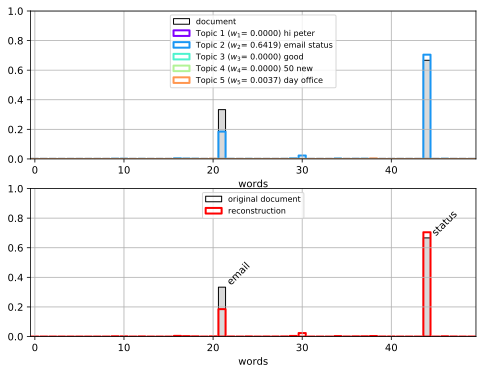

In [16]:
plot_doc_topic(Xtf[4,:], Wnmf[4,:], nmf, vocab)

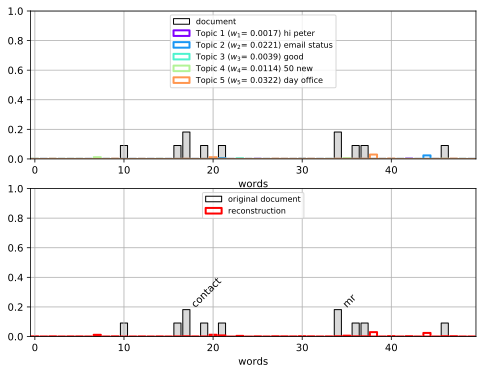

In [17]:
plot_doc_topic(Xtf[3,:], Wnmf[3,:], nmf, vocab)

# Sparseness
- For NMF representation, most topic weights for a document are zero.
  - this is called a _sparse_ representation.
  - each document is only composed of a few topics.

In [18]:
spfig = plt.figure(figsize=(9,5))
for i,e in enumerate([2, 4, 7, 16]):
    plt.subplot(2,4,i+1)
    plt.bar(range(5), Wlsa[e,:])
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([-0.5,4.5,-0.3,1])
    plt.subplot(2,4,i+1+4)
    plt.bar(range(5), Wnmf[e,:])
    plt.axis([-.5,4.5,-0.3,1])
    if i==0:
        plt.ylabel('NMF weights')
    plt.grid(True)
plt.close()

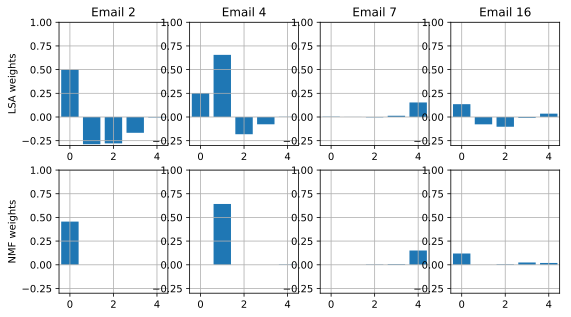

In [19]:
spfig

# Problem with NMF
- _While the weights and component vectors are non-negative, NMF does not enforce them to be  probabilities._
- TF/TFIDF is a probabilistic model of words in a document
  - the vector of probabilities sums to 1
  - probabilities are between 0 and 1
- The NMF components and weights are difficult to interpret.

In [20]:
nfig = plot_topics(nmf, vocab, [0], figsize=(8,2), sp=(1,2,1))
plt.subplot(1,2,2)
plt.bar(range(5), Wnmf[1,:], edgecolor='k');
plt.xlabel('topic number'); plt.ylabel('NMF weight')
plt.grid(True)
plt.close()

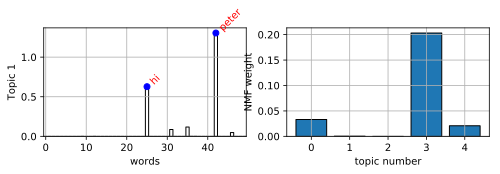

In [21]:
nfig

# Latent Dirichlet Allocation (LDA)
- Use a generative probabilistic framework to model topics and documents.
- A document is composed of a mixture of topics.
  - Each topic has its own distribution of words (topic vector $\boldsymbol{\beta}_k$).
    - Topic vectors are shared among documents.
  - Each document has its own topic weighting.  
    - The d-th document: $\hat{\mathbf{x}}_d = \sum_{k=1}^K \theta_{d,k} \boldsymbol{\beta}_k$
      - $\theta_{d,k}$ is the probability of the k-th topic occurring in the d-th document.
      - $\boldsymbol{\beta}_k$ is the topic vector for the k-th topic.

# LDA graphical model
- Each node is a random variable.
- Plates (boxes) denote a vector of random variables.
  - The size is given in the bottom-right corner.
  
<center><img src="imgs/LDA.jpg" width=800></center>

- LDA generative model
  1. For each topic $k = 1\ldots K$:
    1. Sample the topic vector $\boldsymbol{\beta}_k$ from a Dirichlet distribution.
  2. For each document $d=1\ldots D$:
    1. Sample the topic weights $\theta_d$ from a Dirichlet distribution.
    2. For each word-position $n=1\ldots N$:
      1. Sample a topic $z_{d,n}$.
      2. Sample a word $w_{d,n}$ from topic $z_{d,n}$.

# LDA implementation
- Input X is the word counts from `CountVectorizer`.
- Important parameters:
  - `n_components` - The number of topics ($K$).
  - `doc_topic_prior` - Smoothing parameter ($\alpha$) for the topic weights $\theta$.
  - `topic_word_prior` - Smoothing parameter ($\eta$) for the topic vector $\beta$.
- Note: in the sklearn implementation,
  - the topic weights are not normalized on output.
  - the topic vectors are not normalized in `components_`
  - can be parallelized (`n_jobs`)

In [22]:
# fit LDA model
lda = decomposition.LatentDirichletAllocation(
    n_components=5,
    doc_topic_prior=0.01,
    topic_word_prior=0.01,
    random_state=4487, max_iter=25, n_jobs=-1)
# fit with X
Wlda = lda.fit_transform(X)

# normalize rows to be probabilities
Wlda /= sum(Wlda, axis=1)[:,newaxis]

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


- Topic vectors
  - Note that there is a small probability for each word (controlled by smoothing parameter $\eta$).

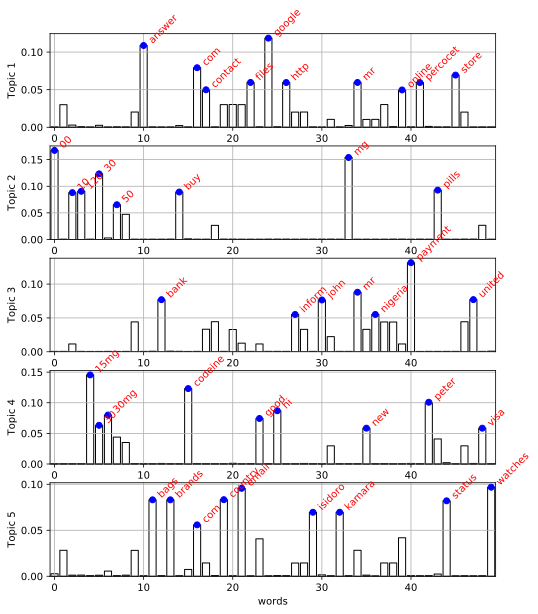

In [23]:
plot_topics(lda, vocab)

- Document vector
  - Note the small probability for each topic (controlled by smoothing parameter $\alpha$).

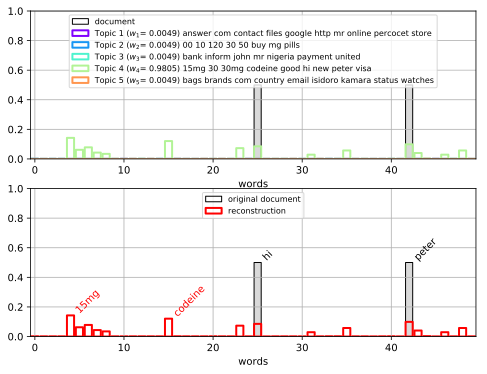

In [24]:
plot_doc_topic(Xtf[2,:], Wlda[2,:], lda, vocab)

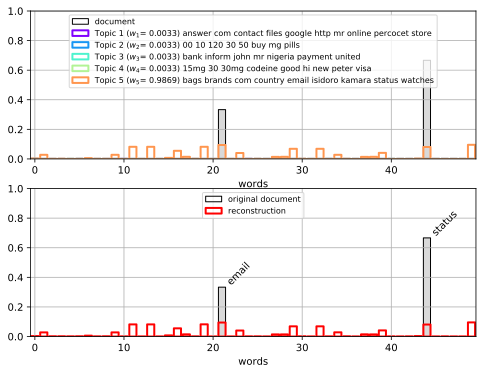

In [25]:
plot_doc_topic(Xtf[4,:], Wlda[4,:], lda, vocab)

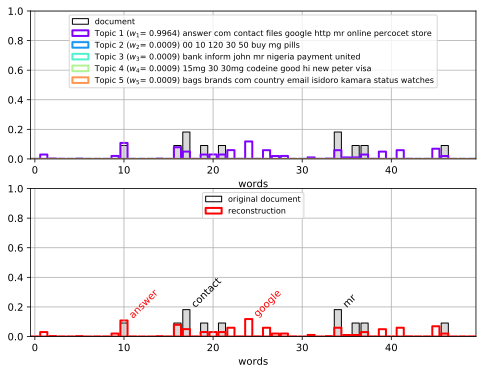

In [26]:
plot_doc_topic(Xtf[3,:], Wlda[3,:], lda, vocab)

# Comparison of topic weights
- LDA weights are probabilities.

In [27]:
compfig = plt.figure(figsize=(9,5))
for i,e in enumerate([2, 4, 7, 16]):
    plt.subplot(3,4,i+1)
    plt.bar(range(5), Wlsa[e,:], edgecolor='k')
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([-.5,4.5,-0.3,1])
    plt.subplot(3,4,i+1+4)
    plt.bar(range(5), Wnmf[e,:], edgecolor='k')
    plt.axis([-0.5,4.5,-0.3,1])
    if i==0:
        plt.ylabel('NMF weights')
    plt.grid(True)
    plt.subplot(3,4,i+1+8)
    plt.bar(range(5), Wlda[e,:], edgecolor='k')
    plt.axis([-0.5,4.5,-0.3,1])
    if i==0:
        plt.ylabel('LDA weights')
    plt.grid(True)

plt.close()

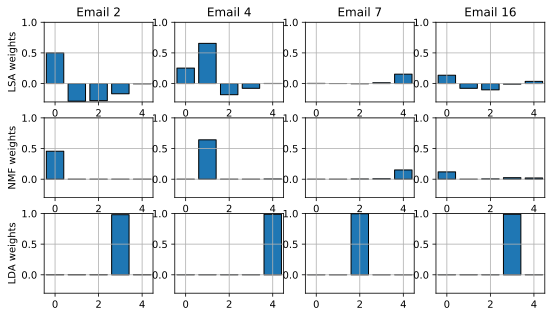

In [28]:
compfig

# Linear Dimensionality Reduction - Summary
- **Goal:** given set of input vectors $\{\mathbf{x}_i\}_{i=1}^n$, with $\mathbf{x}_i\in\mathbb{R}^d$, represent each input vector as lower-dimensional vector $\mathbf{w}_i \in \mathbb{R}^p$.
  - Approximate $\mathbf{x}$ as a weighted sum of basis vectors $\mathbf{v}_j\in \mathbb{R}^d$
    - $\hat{x} = \sum_{j=1}^p w_j \mathbf{v}_j$
    - minimize the reconstruction error of $\hat{\mathbf{x}}$.
  - enables faster processing, or reduces noise.
  
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Objective</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Principal component analysis (PCA)</td>
<td>minimize reconstruction error; preserve the most variance of data</td>
<td>- captures correlated dimensions, removes redundant dimensions, removes noise.<br>- closed-form solution</td>
<td>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Random Projections</td>
<td>sample random basis vectors.</td>
<td>- fast.<br>- preserves pairwise distances between points (up to accuracy factor).</td>
<td>- adds noise to the pairwise distances.</td>
</tr>
<tr>
<td>Fisher's Linear Discriminant (FLD)</td>
<td>maximize class separation</td>
<td>- preserves class separation</td>
<td>- requires class information</td>
</tr>
<tr>
<td>Latent Semantic Analysis (LSA)</td>
<td>minimize reconstruction error</td>
<td>- topic vectors have semantic meaning (co-occuring words)<br>- closed-form solution</td>
<td>- topic weights and topic vectors can be negative<br>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Non-negative Matrix Factorization (NMF)</td>
<td>minimize reconstruction error; non-negative weights and basis vectors.</td>
<td>- "additive" topic/parts model for text or images<br>- sparse topic weights.</td>
<td>- solution requires iterative algorithm.<br>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Latent Dirichlet Allocation (LDA)</td>
<td>document is a mixture of topics.</td>
<td>- generative probabilistic model.<br>- robust when dataset size is small.</td>
<td>- inference/training can be slow for larger datasets.</td>
</tr>
</table>

# Other things
- _Feature Normalization_
  - PCA and LDA are based on the covariance between input dimensions.
  - applying _per-feature_ normalization will yield a different PCA result!
    - normalizing each input dimension changes the relative covariances.

In [29]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None, axbox1=None, axbox2=None):
    if sp is None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    axh = [None, None]
    
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp is None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    axh[0] = plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    plt.scatter(X[:,0], X[:,1], s=5, edgecolor="", c=Y, cmap=mycmap, edgecolors='k')
    if axbox1 is not None:
        plt.axis(axbox1)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Original space (x)')
    
    tmp = plt.xlim()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    Ls = []
    LL = []
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], width=lw, head_width=hw, 
                        color=cols[j], length_includes_head=True)
        Ls.append(tmp)
        LL.append("PC "+str(j))

    plt.plot(Xm[0], Xm[1], 'ks')
    if showleg:
        plt.legend(Ls, LL, loc='lower right')
        
    axh[1] = plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=10, marker='x', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w')

    if axbox2 is not None:
        plt.axis(axbox2)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Low-dim space (w)')
    
    return axh

In [30]:
iris = datasets.load_iris()
X = iris.data[:,(2,1)]
Y = iris.target

# normalize the data
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)

# PCA on original
pca  = decomposition.PCA(n_components=1)
Wpca = pca.fit_transform(X)

# PCA on normalized
pca2  = decomposition.PCA(n_components=1)
Wpca2 = pca2.fit_transform(Xs)

nfig = plt.figure(figsize=(8,9))
axh1 = plot_basis(X, pca.components_, sp=((2,2,1),(2,2,2)), Y=Y)
axh2 = plot_basis(Xs, pca2.components_, sp=((2,2,3),(2,2,4)), Y=Y)
plt.sca(axh2[0])
plt.title('Normalized space (x)')
plt.close()

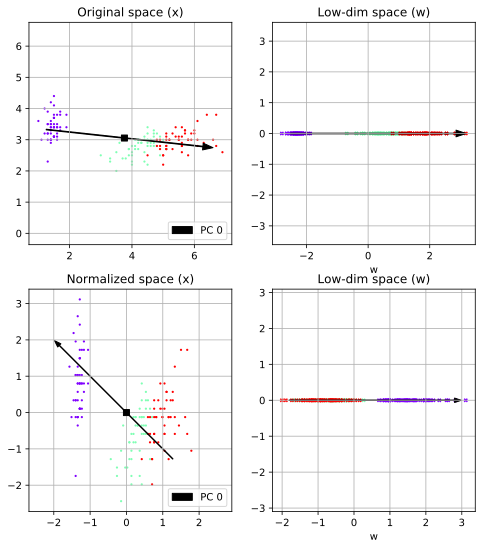

In [31]:
nfig